In [1]:
# This code block is designed to install several Python packages that are essential for financial analysis and optimization tasks. Each line of the code uses the pip installer to add a specific package to your Python environment.

# Install cvxopt package
# cvxopt is a Python library for convex optimization. It provides tools for solving linear and nonlinear convex optimization problems, making it useful for various applications in finance, engineering, and machine learning.
!pip install cvxopt

# Install requests package
# The requests package is a simple, yet powerful HTTP library for Python. It allows you to send HTTP/1.1 requests easily, making it indispensable for tasks that involve interacting with web APIs or fetching data from the internet.
!pip install requests

# Install Empyrial package
# Empyrial is a comprehensive finance library that supports portfolio optimization and performance analysis. It simplifies the process of constructing efficient portfolios and evaluating their risk and return characteristics.
!pip install Empyrial

# Install pandas_market_calendars package
# pandas_market_calendars is a Python library that provides market calendars for different exchanges around the world. It's useful for financial analysis tasks that require knowledge of trading days, holidays, and market open/close times.
!pip install pandas_market_calendars

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# The following line of code is used to install the 'ipython-extensions' package using pip, Python's package installer. 
# The 'ipython-extensions' package contains a collection of extensions for IPython, which enhance its functionality and usability. 
# These extensions can include new magic commands, additional configuration options, and improved integration with other tools and libraries. 
# Installing this package can significantly enhance the interactive Python programming experience, especially within Jupyter notebooks where IPython is commonly used.

!pip install ipython-extensions

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Importing necessary libraries and packages
# First, we attempt to import the yfinance package, which is crucial for fetching financial data.
# If yfinance is not installed, an ImportError is raised to notify the user to install it before proceeding.
try:
    import yfinance as yf
except ImportError:
    raise ImportError("Cannot start without 'yfinance' package.\n Install it before running the code again.")

# Importing a variety of packages for different purposes:
# - matplotlib and matplotlib.pyplot for data visualization
# - pandas for data manipulation and analysis
# - numpy for numerical operations
# - collections for specialized container datatypes
# - bs4 (BeautifulSoup) for web scraping
# - requests for making HTTP requests
# - empyrial for portfolio optimization and performance analysis
# - os for interacting with the operating system
import matplotlib.pyplot as plt
import matplotlib as my
import pandas as pd
import numpy as np
import collections
import bs4 as bs
import warnings  # Adding the 'warnings' module
import requests
import empyrial
import os

# Importing custom modules (assuming these are user-defined or third-party modules not covered in the standard library or common packages)
# These modules are related to financial analysis, such as downloading risk-free rate data, initializing random seeds for simulations,
# optimizing portfolios, engineering stock data, and tracking indexes using genetic algorithms.
import PortfolioOptimizationRiskParameterTuning
import RiskFreeRateDownloader
import RandomSeedInitializer
import PortfolioOptimizer
import StockDataEngineer
import CurvedSurfacePlot
import IndexTrackerGA

# Importing specific functions and classes from packages and modules
# This includes getting market calendars, various functions from custom modules, DataFrame from pandas for handling tabular data,
# Engine from empyrial for running portfolio simulations, and functions from the random module for generating random numbers.
from PortfolioOptimizationRiskParameterTuning import *
from pandas_market_calendars import get_calendar
from RiskFreeRateDownloader import *
from RandomSeedInitializer import *
from PortfolioOptimizer import *
from StockDataEngineer import *
from CurvedSurfacePlot import *
from pandas.core.frame import DataFrame
from IndexTrackerGA import *
from empyrial import empyrial, Engine
from random import randint, choices, uniform, sample
from cvxopt import solvers, matrix  # Importing solvers and matrix from cvxopt for optimization problems
from time import time  # For measuring execution time
from tqdm import tqdm  # For displaying progress bars during lengthy operations

# Configuring the cvxopt solver to not show progress by default to streamline output
solvers.options['show_progress'] = False

# Setting up the environment to ignore warnings, which can be useful to keep the output clean
# However, be cautious as ignoring warnings might hide important messages about deprecated features or potential issues in the code.
warnings.filterwarnings("ignore")

In [4]:
# Import the RandomSeedInitializer class from a library (not specified here).
# This class is likely used to initialize random seeds for reproducibility in experiments or simulations.
randomness = RandomSeedInitializer()

# Set all random seeds using the set_all_seeds method of the RandomSeedInitializer instance.
# The seed value 43860714 is used to ensure that any random operations are reproducible.
# This is crucial in experiments where the same results need to be achieved on multiple runs.
randomness.set_all_seeds(seed=43860714)

In [5]:
%%capture

# Initialize an instance of RiskFreeRateDownloader.
# This object is likely responsible for downloading or calculating the risk-free rate of return,
# which is a theoretical return on an investment with zero risk.
rFreeDownloader = RiskFreeRateDownloader()

# Use the get_risk_free_rate method of the RiskFreeRateDownloader instance to retrieve monthly risk-free rates.
# The result is stored in _monthlyRiskFreeRates, which is expected to be a list or array of rates for each month.
_monthlyRiskFreeRates = rFreeDownloader.get_risk_free_rate()

# Calculate the mean of the monthly risk-free rates.
# np.mean is used to compute the average rate across all months, with axis=0 indicating that the operation is performed column-wise.
# The [0] at the end is used to extract the first element of the result, assuming the mean function returns an array-like object.
_meanMonthlyRFRate = np.mean(_monthlyRiskFreeRates, axis=0)[0]

# Interpolate the monthly data to daily data.
# The interpolate_monthly_data method is called with the 'XNYS' calendar choice, which likely refers to the New York Stock Exchange calendar,
# to ensure the interpolation aligns with the trading days.
# The 'Date' column is specified for date_col, indicating the column in the input data that contains date information.
# The 'monthly_risk_free_rate' is specified for resample_col, indicating the column containing the data to be resampled.
# This process converts monthly risk-free rates to daily rates, considering only the trading days as per the specified calendar.
_dailyRiskFreeRates = rFreeDownloader.interpolate_monthly_data(calendar_choice='XNYS', date_col='Date', resample_col='monthly_risk_free_rate')

In [6]:
%%capture

# Create an instance of the StockDataEngineer class with user_spec set to False
# This instance is used to handle stock data without user-specific configurations
data_reader = StockDataEngineer(user_spec=False)
    
# Get cleaned returns data from the data_reader object and store it in a pandas DataFrame
# The parameters define the range of dates, the data interval, the column of interest, and file saving options
clean_returns = pd.DataFrame(
    data_reader.get_cleaned_returns(
        start_date =(2000, 1, 1), # Start date for the data
        end_date   =(2024, 3, 31), # End date for the data
        index_col  ='Date', # Column to use as the index of the DataFrame
        interval   ='1d', # Interval for the data (daily in this case)
        column     ='Adj Close', # Column to be cleaned and analyzed
        save_as_h5 =True, # Option to save the cleaned data as an H5 file
        save_as_csv=True # Option to save the cleaned data as a CSV file
    )
)

In [7]:
# Subtracting the daily risk-free rate from the cleaned returns
# This operation is performed to adjust the returns of the stocks for the risk-free rate, 
# allowing for the calculation of excess returns over the risk-free rate. This is a common 
# practice in finance to evaluate the performance of an investment by comparing it to a 
# risk-free benchmark.

# 'clean_returns' is a pandas DataFrame containing the cleaned returns data for a stock or portfolio.
# 'riskFreeRates' is a pandas DataFrame with a column 'daily_rFrate' that contains the daily risk-free rate.
# The operation uses the 'sub' method of pandas DataFrame to subtract the 'daily_rFrate' from each corresponding 
# entry in 'clean_returns'. The 'axis=0' parameter ensures that the subtraction is done row-wise, 
# matching each date in 'clean_returns' with the corresponding date's risk-free rate in 'riskFreeRates'.

cleaned_returns = clean_returns.sub(_dailyRiskFreeRates['daily_rFrate'], axis=0)
# The result is stored in 'cleaned_returns', which now holds the excess returns of the stocks or portfolio over the risk-free rate.

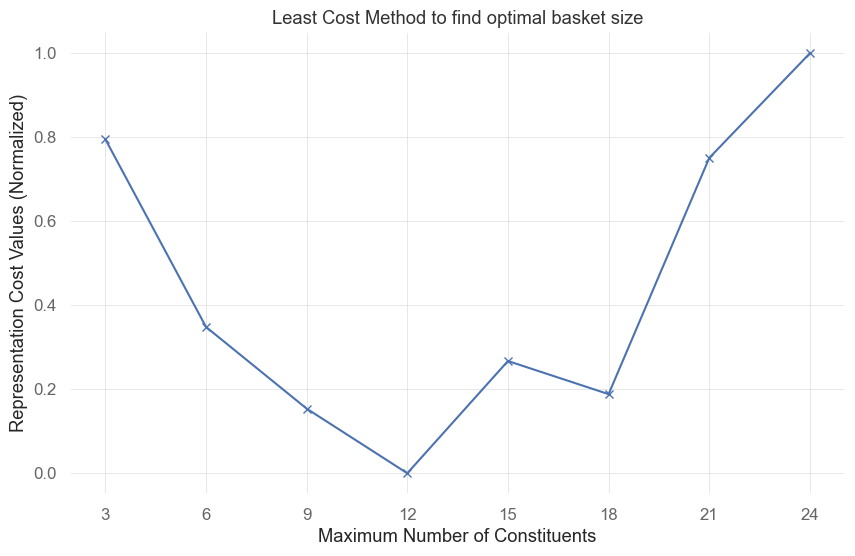

In [8]:
### DO NOT EXECUTE

# Initialize empty lists to store output values
_cValue      = []    # List to store cost values obtained from the index tracking algorithm
_namesStocks = []    # List to store names of stocks selected by the index tracking algorithm
_Karr        = []    # List to store different values of K (maximum number of securities)

# Loop through values of K from 3 to 19 in increments of 3
for k in np.arange(3, 25, 3): 
    # Create an instance of IndexTrackerGA with specified parameters:
    # 'securities_data' is the DataFrame of cleaned returns,
    # 'max_securities' is the maximum number of securities to include in the index,
    # 'index_name' is the name of the index to track (e.g., 'SPY' for S&P 500).
    InitGA = IndexTrackerGA(securities_data=cleaned_returns, max_securities=k, index_name='SPY')
    
    # Call the track_index method of the IndexTrackerGA instance to find the optimal basket of stocks
    # that mimics the performance of the SPY index with the current value of K.
    _output =InitGA.track_index()
    
    # Append the cost value, names of stocks, and value of K to their respective lists.
    # The 'cost_value' represents how well the selected basket of stocks tracks the SPY index,
    # with lower values indicating better tracking performance.
    _cValue.append(_output['cost_value'])
    _namesStocks.append(_output['names'])
    _Karr.append(k)

# Normalize the cost values using min-max scaling to bring all values into the range [0, 1].
# This normalization helps in comparing cost values on a consistent scale.
_cValue = (np.array(_cValue) - np.min(_cValue, axis=0)) / (np.max(_cValue, axis=0) - np.min(_cValue, axis=0))

# Plot the normalized cost values against the values of K to visualize how the cost changes with the number of constituents.
# This plot can help in identifying the 'elbow point', which is the point after which adding more constituents
# does not significantly improve the tracking performance, indicating an optimal basket size.
plt.plot(np.arange(3, 25, 3), _cValue, 'bx-')  # 'bx-' specifies the style of the plot (blue color, x markers, solid lines)
plt.xlabel('Maximum Number of Constituents')   # Label for the x-axis
plt.ylabel('Representation Cost Values (Normalized)')  # Label for the y-axis
plt.xticks(np.arange(3, 25, 3))  # Set the tick marks on the x-axis to match the values of K used in the loop
plt.title('Least Cost Method to find optimal basket size')  # Title of the plot
plt.savefig("Data/GeneticAlgorithmDrivenRepresentativeBasket.png")
plt.show();  # Display the plot

In [14]:
### DO NOT EXECUTE

# Create a DataFrame of the names of stocks selected by the elbow method, indexed by the value of K
# This DataFrame (_namesStocksDF) holds the stock names with their corresponding K values as the index.
# The _namesStocks variable is expected to be a list of stock names, and _Karr a list of K values (integers) representing different cluster sizes.
_namesStocksDF = pd.DataFrame(_namesStocks, index=_Karr)

# Create another DataFrame for the cost values associated with each K, indexed by the value of K
# This DataFrame (_cValueStockDF) contains the cost values for each K, with K values as the index.
# The _cValue variable is expected to be a list of cost values associated with each K value, indicating the cost of clustering with that many clusters.
_cValueStockDF = pd.DataFrame(_cValue, index=_Karr)

# Extract the list of tickers for the basket size with K chosen as the first k such that cost is less than 0.00001
# This step identifies the optimal number of clusters (K) based on the elbow method, where the cost falls below a threshold (0.00001 in this case),
# and then selects the stock names associated with this K value.
# The elbow method helps in determining the optimal number of clusters by looking for a "knee" in the cost plot, where additional clusters do not significantly reduce the cost.
_elbowStocks = _namesStocksDF.loc[_cValueStockDF[_cValueStockDF[0] <= 0.00000000001].index[0]].values.tolist()

# Create a new list '_listStocks' by iterating through each element 'S' in the list '_elbowStocks'
# This list comprehension filters out any None values from the '_elbowStocks' list, ensuring that only valid stock names are included.
# It iterates through each stock name 'S' in '_elbowStocks' and includes it in the new list if it is not None.
# This step is crucial for cleaning the data, ensuring that the final list only contains valid stock names for further analysis or operations.
_listStocks = [S for S in _elbowStocks 
               # Only include the element 'S' in the new list if it is not None
               if S is not None]

# Save to csv
# This line saves the cleaned list of stock names ('_listStocks') to a CSV file named '_elbowStocks' in the 'Data' directory.
# The DataFrame is created with '_listStocks' and no index, then saved using the 'to_csv' method.
# This operation is useful for exporting the result for further analysis, sharing with others, or for record-keeping.
pd.DataFrame(_listStocks, index=None).to_csv('Data/_elbowStocks.csv')

In [10]:
# DO NOT EXECUTE THE 2 CODE BLOCS ABOVE
# Read a CSV file named '_elbowStocks' located in the 'Data' directory.
# The 'pd.read_csv()' function is used to load the CSV file into a DataFrame.
# The 'Data/_elbowStocks' specifies the path to the CSV file.
_listStocks = pd.read_csv('Data/_elbowStocks')['0'].values.tolist()
# After reading the CSV file, we select the column named '0' from the DataFrame.
# The '.values' attribute is then used to extract the data from the selected column as an array.
# Finally, the '.tolist()' method converts this array into a Python list.
# The resulting list is stored in the variable '_listStocks'.

In [11]:
%%capture

# Define a list of dictionaries, each representing a risk management strategy.
# "Stop Loss" strategies trigger a sell when an investment falls below a certain percentage,
# indicating the maximum loss an investor is willing to tolerate before selling to prevent further losses.
# "Max Drawdown" strategies, on the other hand, limit the maximum percentage loss in a portfolio's value
# over a specified period, aiming to control the overall risk by preventing substantial declines in portfolio value.
# These strategies are defined with negative values to represent a decrease in value.
risk_managers = [
    {"Stop Loss": -0.05},
    {"Stop Loss": -0.10},
    {"Stop Loss": -0.15},
    {"Stop Loss": -0.20},
    {"Stop Loss": -0.25},
    {"Stop Loss": -0.30},    
    {"Stop Loss": -0.35},
    {"Stop Loss": -0.40},
    {"Stop Loss": -0.45},
    {"Stop Loss": -0.50},
    {"Max Drawdown": -2.00}, 
    {"Max Drawdown": -1.85},
    {"Max Drawdown": -1.75},
    {"Max Drawdown": -1.50},
    {"Max Drawdown": -1.35},
    {"Max Drawdown": -1.15}, 
    {"Max Drawdown": -1.00},
    {"Max Drawdown": -0.85},
    {"Max Drawdown": -0.75},
    {"Max Drawdown": -0.50},    
]

# Initialize the portfolio optimizer with the defined risk managers.
# This optimizer, `PortfolioOptimizationRiskParameterTuning`, is designed to test each risk management strategy
# to find the one that optimizes portfolio performance. The parameter `LTCM=False` indicates that the
# Long-Term Capital Management (LTCM) strategy is not used in this optimization process. LTCM is a reference to
# a famous hedge fund that failed due to high-risk financial strategies. Setting this parameter to False
# might imply a shorter-term approach to risk management.
portfolio_optimizer = PortfolioOptimizationRiskParameterTuning(risk_managers, LTCM=False)

# Optimize the portfolio by finding the best risk management strategy, rebalance periods, and other parameters.
# `_listStocks` is a list of stocks to be included in the portfolio, representing the investment universe.
# `_meanMonthlyRFRate` is the mean monthly risk-free rate, used as a benchmark for performance comparison.
# The risk-free rate is a theoretical return on an investment with zero risk, serving as a baseline to assess
# the performance of riskier investments.
# The function `optimize_portfolio` returns multiple values:
# - `rMngr`: the best risk manager from the provided strategies that optimizes portfolio performance.
# - `rebalance_periods`: the optimal periods at which the portfolio should be rebalanced to maintain the desired risk profile.
# - `ALPHA_values`: a set of performance measures indicating the portfolio's ability to generate returns above the benchmark.
# - `STABILITY_values`: measures of return consistency, indicating how stable the portfolio's returns are over time.
# - `CAGR_values`: compound annual growth rate values, representing the mean annual growth rate of an investment over a specified time period, assuming the profits are reinvested at the end of each year.
rMngr, rebalance_periods, ALPHA_values, STABILITY_values, CAGR_values = portfolio_optimizer.optimize_portfolio(_listStocks, risk_free_rate=_meanMonthlyRFRate)

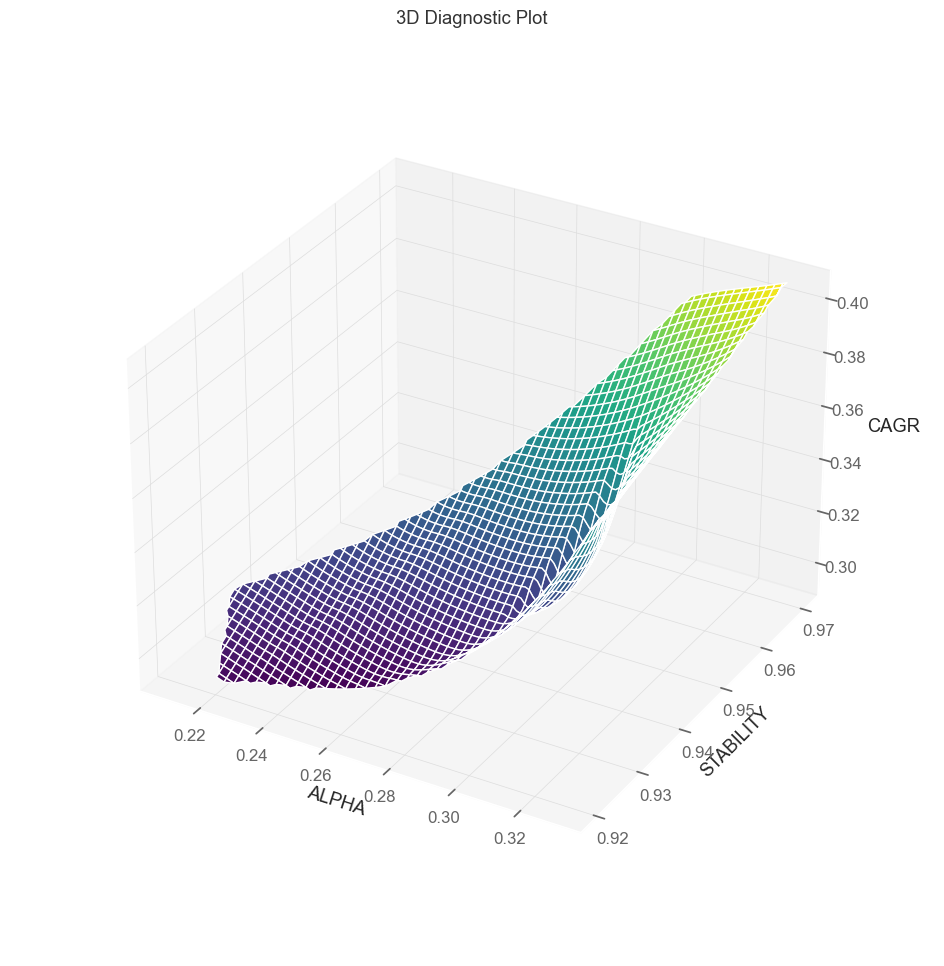

In [12]:
# First, we create an instance of the CurvedSurfacePlot class. This class is likely designed to generate and display
# 3D surface plots. The constructor for this class takes three arguments:
# 1. CAGR_values: A sequence of values representing the Compound Annual Growth Rate. This could be a list or array.
# 2. ALPHA_values: A sequence of values representing some metric or parameter named ALPHA. Its exact meaning would
#    depend on the context of the problem or the data being visualized.
# 3. STABILITY_values: A sequence of values representing stability metrics or parameters. Like the other parameters,
#    the specifics of what "stability" means would depend on the context.
surface_plot = CurvedSurfacePlot(np.array(CAGR_values), np.array(ALPHA_values), np.array(STABILITY_values))

# After creating the CurvedSurfacePlot object with the specified parameters, we call the plot_surface method on this
# object. This method is responsible for generating and displaying the 3D surface plot based on the CAGR, ALPHA, and
# STABILITY values provided earlier. The plot will likely show how these three parameters interact with each other
# in a 3D space, providing insights into their relationships and dependencies.
surface_plot.plot_surface(filename=True)

In [13]:
# This block of code is designed to analyze and report on the performance and characteristics of a portfolio based on
# various metrics such as Alpha, Stability, and CAGR (Compound Annual Growth Rate). Each print statement provides
# specific insights into the portfolio's performance and optimization strategies.

# Reports the maximum value of Alpha, indicating the highest performance relative to the risk taken, according to the
# Alpha metric. Alpha is a common measure used to determine an investment's performance on a risk-adjusted basis.
print(f"The maximized value of Alpha for the risk-adjusted optimum strategy is: {ALPHA_values[np.argmax(ALPHA_values)]}.")

# Displays the maximum value of Stability, suggesting the strongest consistency or reliability in the time-series of
# portfolio returns. Stability is crucial for understanding the predictability and risk of investments over time.
print(f"The optimum strength of the time-series of portfolio returns is: {STABILITY_values[np.argmax(STABILITY_values)]}.")

# Shows the Stability value corresponding to the maximum Alpha value, linking high performance with the strength of
# return series. This indicates how well the portfolio performs at its best risk-adjusted performance level.
print(f"The optimum strength of the time-series of portfolio returns is obtained simultaneously with Alpha, {STABILITY_values[np.argmax(ALPHA_values)]}.")

# Reports the maximum CAGR, which represents the mean annual growth rate of an investment over a specified time period
# longer than one year. It's a measure of the returns on the investment as if it had grown at a steady rate.
print(f"The CAGR of the portfolio returns is: {CAGR_values[np.argmax(CAGR_values)]}.")

# Links the maximized CAGR with the maximized Alpha, showing when both these metrics are optimized simultaneously.
# This can indicate a particularly strong investment strategy where both growth and risk-adjusted performance are high.
print(f"The CAGR of the portfolio returns is maximized simultaneously with Alpha: {CAGR_values[np.argmax(ALPHA_values)]}.")

# Identifies the Risk Management Strategy that maximizes Alpha, suggesting the best approach to managing risk while
# achieving high adjusted returns. Risk management is key to preserving capital and achieving consistent returns.
print(f"The optimum Risk Management Strategy to maximize Alpha is: {rMngr[np.argmax(ALPHA_values)]}.")

# Determines the best Rebalancing Frequency to maximize Alpha, indicating how often the portfolio should be adjusted
# to maintain its optimal asset allocation. Regular rebalancing is essential to managing risk and capturing profits.
print(f"The optimum Rebalancing Frequency to maximize Alpha is: {rebalance_periods[np.argmax(ALPHA_values)]}.")

The maximized value of Alpha for the risk-adjusted optimum strategy is: 0.33.
The optimum strength of the time-series of portfolio returns is: 0.97.
The optimum strength of the time-series of portfolio returns is obtained simultaneously with Alpha, 0.97.
The CAGR of the portfolio returns is: 0.408.
The CAGR of the portfolio returns is maximized simultaneously with Alpha: 0.408.
The optimum Risk Management Strategy to maximize Alpha is: {'Stop Loss': -0.05}.
The optimum Rebalancing Frequency to maximize Alpha is: quarterly.
